## Import Libraries


In [2]:
!pip install imutils

  Using cached imutils-0.5.4-py3-none-any.whl



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import GroupKFold
import random
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess_input
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.models import load_model
import pickle




## Looking at sample MRI images

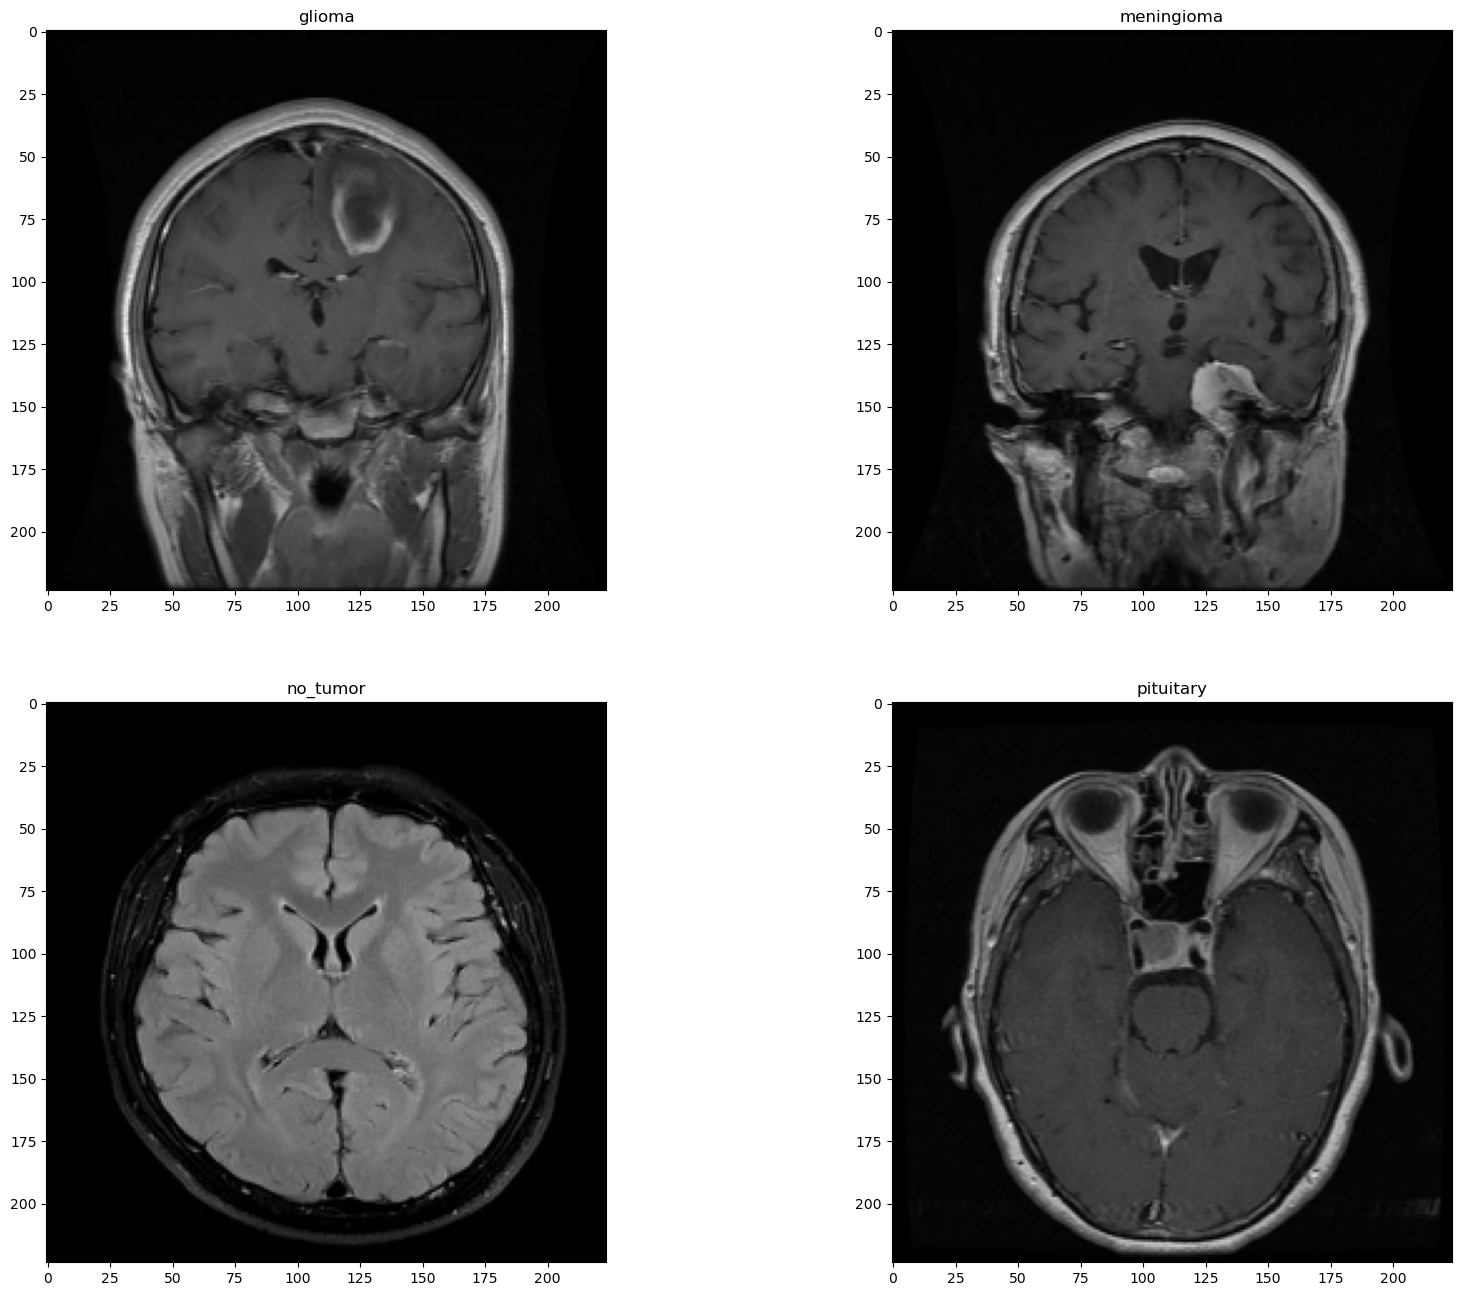

In [2]:
#data_dir = ("C:/Users/harsh/Downloads/capstone/Dataset/Train") #Input the Training directory
data_dir = ("E:/SRM college/SEM-8/Dataset/Train")
categories = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
plt.figure(figsize=(20, 16))

#images_path = ['/glioma/Train-glioma-99.jpg', '/meningioma/Train-meningioma-99.jpg', '/notumor/Train-notumor-99.jpg', '/pituitary/Train-pituitary-99.jpg'] # 4 pics from each tumor heading
images_path = ['/glioma/Tr-gl_0100.jpg', '/meningioma/Tr-me_0100.jpg', '/notumor/Tr-no_0100.jpg', '/pituitary/Tr-pi_0100.jpg'] # 4 pics from each tumor heading

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(categories[i])



## Cropping images to make them all the same size

In [3]:
def crop_img(img):
    """
	Finds the exterior points on the image and crops to that limit
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3),0)
    
    #Threshold the image + erode and increase size for better image
    
    thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations =2)
    
    #Find the biggest contour(curve that is a whole) and present that as the image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    #Finding the exterior points
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBottom = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img



    

In [4]:
#img = cv2.imread("C:/Users/harsh/Downloads/capstone/Dataset/Train/glioma/Train-glioma-99.jpg") #Looking at a sample image
img = cv2.imread("E:/SRM college/SEM-8/Dataset/Train/glioma/Tr-gl_0100.jpg")
img = cv2.resize(
            img,
            dsize = (224,224),
            interpolation = cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3,3),0)
    
#Threshold the image + erode and increase size for better image
    
thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations = 2)
thresh = cv2.dilate(thresh, None, iterations =2)
    
#Find the biggest contour(curve that is a whole) and present that as the image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)
    
#Finding the exterior points
    
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBottom = tuple(c[c[:, :, 1].argmax()][0])

#Inputting the contour
img_cnt = cv2.drawContours(img.copy(), [c], -1,(0,255,255),4)

# Add exterior points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255,0,0), -1)
img_pnt = cv2.circle(img_pnt, extBottom, 8, (255,255,0), -1)

#Crop it
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()



Text(0.5, 1.0, 'Enlarged Image')

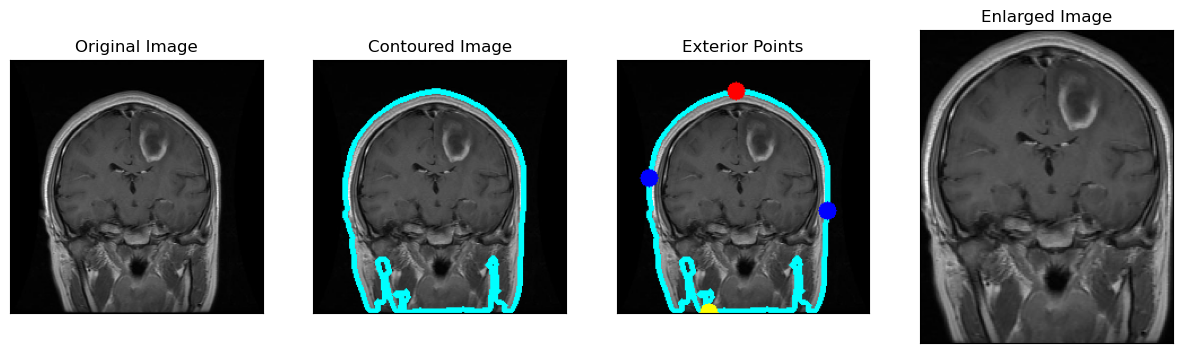

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Contoured Image')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Exterior Points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Enlarged Image')


## Cropping all the images

In [16]:
if __name__== '__main__':
    #training = "C:/Users/harsh/Downloads/capstone/Dataset/Train"
    training = "E:/SRM college/SEM-8/Dataset/Train"
    testing = "E:/SRM college/SEM-8/Dataset/Test"
    #testing = "C:/Users/harsh/Downloads/capstone/Dataset/Test"
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)
    IMG_SIZE = 256
    
    ##Writing images for the training set
    
    for dir in training_dir:
        save_path = 'E:/SRM college/SEM-8/brain_tumors/cropped/Training/' + dir
        path = os.path.join(training,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
    
    ## Writing images to the testing set
    for dir in testing_dir:
        save_path = 'E:/SRM college/SEM-8/brain_tumours/cropped/Testing/'+ dir
        path = os.path.join(testing,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
    
        

In [6]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] #Image training
y_train = [] #Label training
x_test = [] #Image testing
y_test = [] #Label testing

image_size = 200

for label in labels:
    trainPath = os.path.join("E:/SRM college/SEM-8/brain_tumors/cropped/Training",label)
    #trainPath = os.path.join("")
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath,file), 0) #Gray Images
        image = cv2.bilateralFilter(image ,2,50,50)   #Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)    #Colored Image
        image = cv2.resize(image , (image_size, image_size))    #Resize the image to 150*150
        x_train.append(image)
        y_train.append(labels.index(label))
        
    trainPath = os.path.join("E:/SRM college/SEM-8/brain_tumours/cropped/Testing",label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath,file), 0) #Gray Images
        image = cv2.bilateralFilter(image ,2,50,50)   #Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)    #Colored Image
        image = cv2.resize(image , (image_size, image_size))    #Resize the image to 150*150
        x_test.append(image)
        y_test.append(labels.index(label))
        


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 489.20it/s]


In [7]:
x_train = np.array(x_train) / 255.0  #Creates an image array for normalization
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

(5712, 200, 200, 3)
(1311, 200, 200, 3)


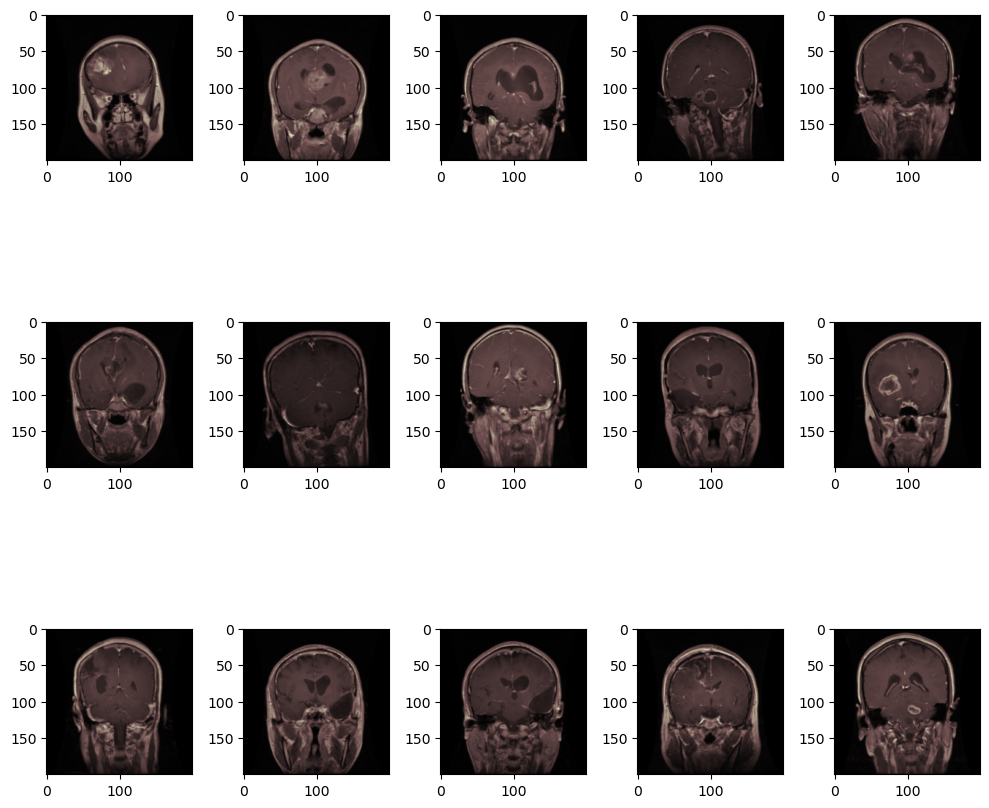

In [8]:
images = [x_train[i] for i in range(15)]
fig , axes = plt.subplots(3,5, figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(images,axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Setting up the model

In [9]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_val.shape)

(1143, 200, 200, 3)


## Actual Flipping of the images
 - increased the parameters of change to ensure maximum accuracy

In [11]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)
os.mkdir('preview_4')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview_3', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

In [12]:
train_dataset_location="E:/SRM college/SEM-8/brain_tumors/cropped/Training"
test_dataset_location="E:/SRM college/SEM-8/brain_tumours/cropped/Testing"

In [13]:
train_image_gen = datagen.flow_from_directory(train_dataset_location, 
                                                target_size=(200,200,3)[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

test_image_gen = datagen.flow_from_directory(test_dataset_location, 
                                                target_size=(200,200,3)[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


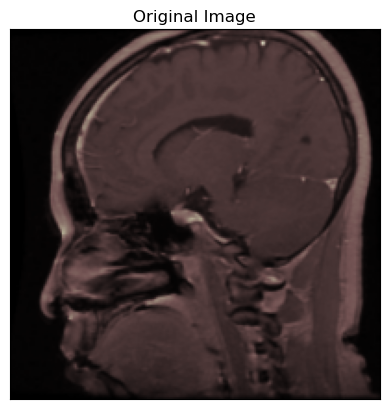

<Figure size 1500x600 with 0 Axes>

In [14]:
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_4/'):
    img = cv2.imread('preview_4/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [15]:
datagen.fit(x_train)

##Using VGG instead of ResNet 


In [14]:
# load base model
vgg16_weight_path = "E:/SRM college/SEM-8/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=(200,200,3)
)

In [15]:
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
vgg16_model = keras.Sequential([
    
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    
    base_model, #vgg16
    
    layers.Flatten(),
    layers.Dropout(.25),
    layers.Dense(units=256, activation="relu"),
    layers.Dense(units=len(labels), activation="softmax"),
])

In [16]:
vgg16_model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(epsilon=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#including early stopping to revent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=40,
    min_delta=0.001,
    restore_best_weights=True,
)

In [17]:
history = vgg16_model.fit(
    x = x_train,
    y = y_train,
    validation_data= (x_test,y_test),
    batch_size = 32,
    epochs=5,
    callbacks=[early_stopping],
    verbose=(2),
 )

Epoch 1/5
143/143 - 1804s - loss: 0.5798 - accuracy: 0.7765 - val_loss: 0.3033 - val_accuracy: 0.8841 - 1804s/epoch - 13s/step
Epoch 2/5
143/143 - 1820s - loss: 0.2525 - accuracy: 0.9050 - val_loss: 0.2655 - val_accuracy: 0.9008 - 1820s/epoch - 13s/step
Epoch 3/5
143/143 - 1803s - loss: 0.1621 - accuracy: 0.9444 - val_loss: 0.1474 - val_accuracy: 0.9428 - 1803s/epoch - 13s/step
Epoch 4/5
143/143 - 1800s - loss: 0.1346 - accuracy: 0.9538 - val_loss: 0.1017 - val_accuracy: 0.9664 - 1800s/epoch - 13s/step
Epoch 5/5
143/143 - 1780s - loss: 0.1049 - accuracy: 0.9634 - val_loss: 0.1533 - val_accuracy: 0.9420 - 1780s/epoch - 12s/step


In [16]:
from keras.models import load_model
vgg_model = load_model('h5_vgg_model.h5')

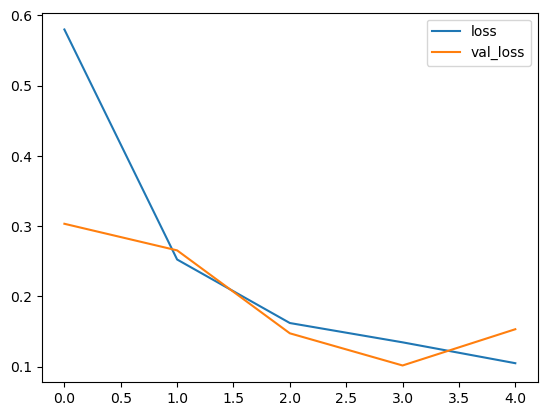

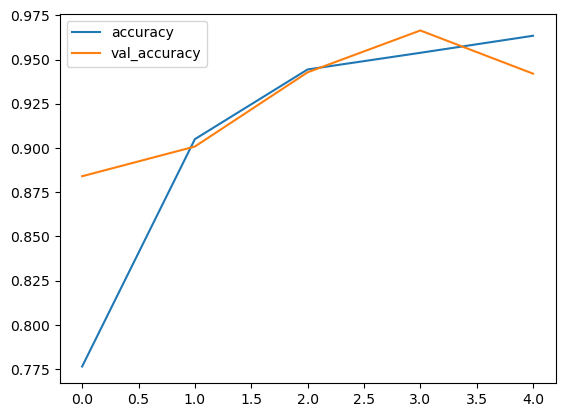

In [21]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss','val_loss']].plot()
history_frame.loc[:, ['accuracy','val_accuracy']].plot();


In [13]:
pred = vgg_model.predict(x_test)

# Get the index of the maximum value along the second axis (axis=1)
pred_classes = np.argmax(pred, axis=1)

# Convert indices to class labels
pred_labels = [labels[i] for i in pred_classes]


41/41 [==============================] - 153s 4s/step


In [14]:
print(classification_report(np.argmax(y_test,axis=1), pred_classes,target_names=['glioma','meningioma','notumor','pituitary']))


              precision    recall  f1-score   support

      glioma       0.81      0.93      0.87       300
  meningioma       0.81      0.92      0.86       306
     notumor       1.00      0.79      0.88       405
   pituitary       0.95      0.95      0.95       300

    accuracy                           0.89      1311
   macro avg       0.89      0.90      0.89      1311
weighted avg       0.90      0.89      0.89      1311



41/41 [==============================] - 161s 4s/step


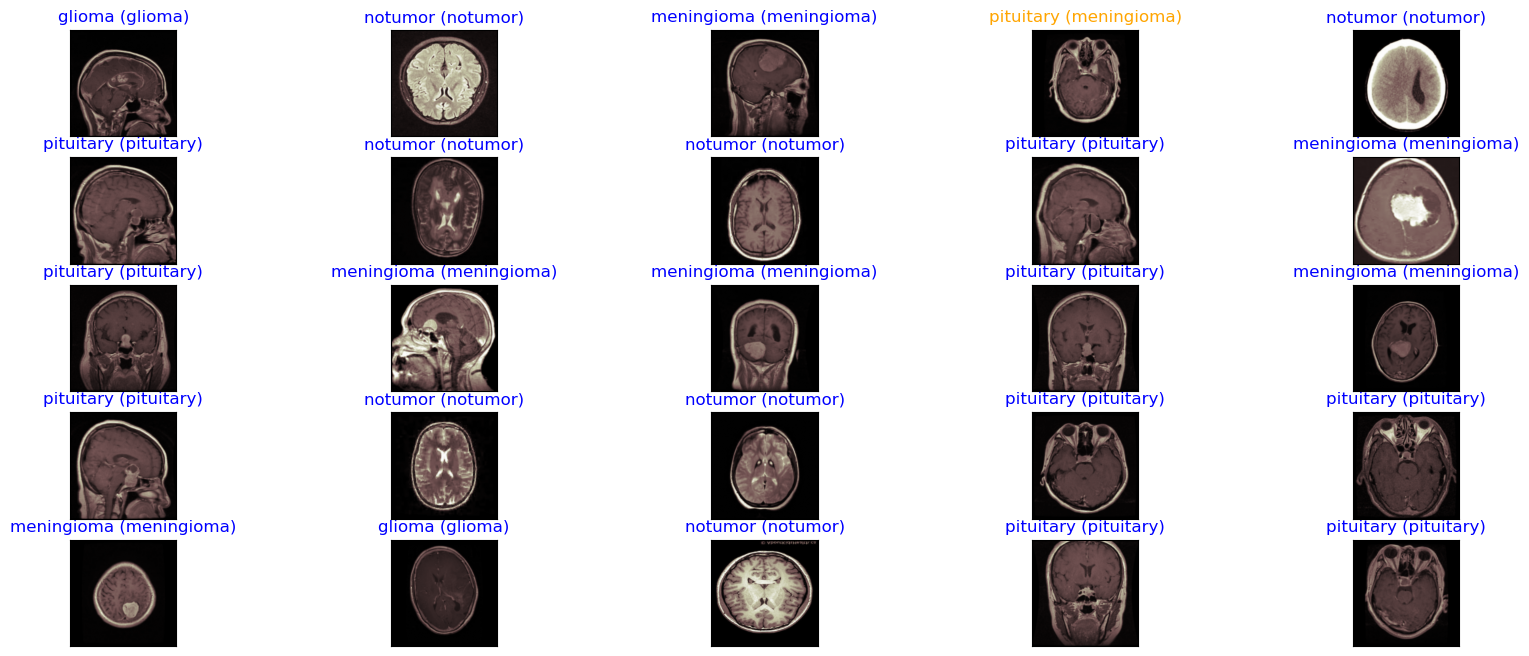

In [19]:
y_hat = loaded_vgg16_model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','notumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

## Resnet101

In [30]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

In [32]:
from tensorflow.keras.applications import ResNet101

In [34]:
model = Sequential()
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
resnet101_model.trainable = False 

171446536/171446536 [==============================] - 48s 0us/step


In [35]:
model.add(resnet101_model)

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [37]:
from tensorflow.keras.losses import CategoricalCrossentropy
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [43]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=15, callbacks=[early_stop_loss, early_stop_val_loss],batch_size=64)

Epoch 1/15
357/357 [==============================] - 579s 2s/step - loss: 1.0997 - accuracy: 0.5630 - val_loss: 0.9523 - val_accuracy: 0.6079
Epoch 2/15
357/357 [==============================] - 585s 2s/step - loss: 1.0393 - accuracy: 0.5937 - val_loss: 0.9060 - val_accuracy: 0.6194
Epoch 3/15
357/357 [==============================] - 588s 2s/step - loss: 0.9665 - accuracy: 0.6134 - val_loss: 0.8802 - val_accuracy: 0.6491
Epoch 4/15
357/357 [==============================] - 586s 2s/step - loss: 0.9517 - accuracy: 0.6231 - val_loss: 0.8664 - val_accuracy: 0.6590
Epoch 5/15
357/357 [==============================] - 585s 2s/step - loss: 0.9327 - accuracy: 0.6406 - val_loss: 0.7956 - val_accuracy: 0.6827
Epoch 6/15
357/357 [==============================] - 623s 2s/step - loss: 0.9209 - accuracy: 0.6434 - val_loss: 0.7888 - val_accuracy: 0.6842
Epoch 7/15
357/357 [==============================] - 634s 2s/step - loss: 0.9102 - accuracy: 0.6434 - val_loss: 0.8171 - val_accuracy: 0.6850

In [44]:
model.evaluate(train_image_gen)[1]

357/357 [==============================] - 462s 1s/step - loss: 0.6604 - accuracy: 0.7299


0.7298669219017029

In [45]:
model.evaluate(test_image_gen)[1]

82/82 [==============================] - 111s 1s/step - loss: 0.8054 - accuracy: 0.6766


0.6765827536582947

In [17]:
from keras.models import load_model
res_model = load_model('h5_resnet_model.h5')

## cnn model

In [25]:
# Custom CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the architecture of the custom CNN model
custom_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(labels), activation='softmax')
])

In [26]:
# Compile the model
custom_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
# Train the model
history_custom_cnn = custom_cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
72/72 [==============================] - 117s 2s/step - loss: 0.8057 - accuracy: 0.6752 - val_loss: 0.5153 - val_accuracy: 0.8233
Epoch 2/10
72/72 [==============================] - 112s 2s/step - loss: 0.4072 - accuracy: 0.8413 - val_loss: 0.4212 - val_accuracy: 0.8373
Epoch 3/10
72/72 [==============================] - 113s 2s/step - loss: 0.2883 - accuracy: 0.8934 - val_loss: 0.2914 - val_accuracy: 0.8933
Epoch 4/10
72/72 [==============================] - 112s 2s/step - loss: 0.1939 - accuracy: 0.9282 - val_loss: 0.2716 - val_accuracy: 0.8994
Epoch 5/10
72/72 [==============================] - 112s 2s/step - loss: 0.1567 - accuracy: 0.9394 - val_loss: 0.3725 - val_accuracy: 0.8898
Epoch 6/10
72/72 [==============================] - 112s 2s/step - loss: 0.1011 - accuracy: 0.9632 - val_loss: 0.2689 - val_accuracy: 0.9134
Epoch 7/10
72/72 [==============================] - 112s 2s/step - loss: 0.0503 - accuracy: 0.9829 - val_loss: 0.3675 - val_accuracy: 0.9108
Epoch 8/10
72

In [18]:
from keras.models import load_model
cnn_model = load_model('h5_cnn_model.h5')

In [17]:
pred_cnn = cnn_model.predict(x_test)

# Get the index of the maximum value along the second axis (axis=1)
pred_classes_cnn = np.argmax(pred_cnn, axis=1)

# Convert indices to class labels
pred_labels_cnn = [labels[i] for i in pred_classes_cnn]


41/41 [==============================] - 9s 231ms/step


In [18]:
print(classification_report(np.argmax(y_test,axis=1), pred_classes_cnn,target_names=['glioma','meningioma','notumor','pituitary']))


              precision    recall  f1-score   support

      glioma       0.63      0.66      0.64       300
  meningioma       0.45      0.46      0.45       306
     notumor       0.57      0.75      0.65       405
   pituitary       0.93      0.46      0.62       300

    accuracy                           0.60      1311
   macro avg       0.64      0.58      0.59      1311
weighted avg       0.64      0.60      0.60      1311



## ensemble model

In [ ]:
 import numpy as np
 import tensorflow
 from sklearn.ensemble import BaggingClassifier
 from sklearn.tree import DecisionTreeClassifier
 from sklearn.metrics import accuracy_score
 # Define the base neural network model (e.g., loaded_custom_cnn_model)
 base_model = [loaded_vgg16_model, loaded_resnet101_model, loaded_custom_cnn_model]
 # Create a list to store the base models
 base_models = []
 # Train multiple neural network models with different initializations or hyperparameters
 for model in base_model:
    # Create a clone of the base model
    model_clone = tensorflow.keras.models.clone_model(model)
    
    # Compile the model
    model_clone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model (use appropriate training data)
    history = model_clone.fit(x_train, y_train, epochs=5, batch_size=64, verbose=0)
    
    # Append the trained model to the list of base models
    base_models.append(model_clone)

In [22]:
base_models = []
base_models.append(model)

In [23]:
from keras.models import load_model
model = load_model('h5_model_clone.h5')

In [ ]:
base_model = [loaded_vgg16_model, loaded_resnet101_model, loaded_custom_cnn_model]

In [24]:
# Make predictions on the test data using each base model
base_model_predictions = []
for model in base_models:
   predictions = model.predict(x_test)
   base_model_predictions.append(predictions)
# Stack the predictions of all base models
stacked_predictions = np.stack(base_model_predictions, axis=-1)
stacked_predictions = stacked_predictions.reshape((len(x_test), -1))
# Convert labels to integer format
y_test_int = np.argmax(y_test, axis=1)

41/41 [==============================] - 7s 172ms/step


In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# Define the meta-learner (e.g., decision tree classifier)
meta_learner = DecisionTreeClassifier()
# Train the meta-learner using bagging
ensemble_model = BaggingClassifier(meta_learner, n_estimators=10, random_state=42)
ensemble_model.fit(stacked_predictions, y_test_int)

BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [27]:
 # Make predictions using the bagging classifier
 ensemble_predictions = ensemble_model.predict(stacked_predictions)
 # Calculate ensemble accuracy
 ensemble_accuracy = accuracy_score(y_test_int, ensemble_predictions)
 print(f'Ensemble Accuracy: {ensemble_accuracy}')

Ensemble Accuracy: 0.9839816933638444


In [28]:
print(classification_report(y_test_int, ensemble_predictions,target_names=['glioma','meningioma','notumor','pituitary']))

              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       300
  meningioma       0.98      0.98      0.98       306
     notumor       0.99      0.98      0.99       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



## Explainable Model (LIME)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


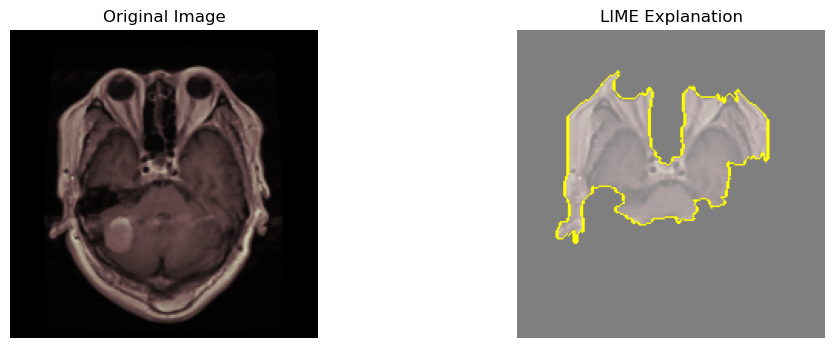

In [36]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

# Assuming x_test contains your test images
# Pick a random sample for explanation (adjust index as needed)
random_index = random.randint(0, len(x_test)-1)
image_to_explain = x_test[random_index]

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define the predict function for your model
predict_function = lambda images: vgg_model.predict(images.reshape((-1, 200, 200, 3)))

# Explain the prediction for the selected image
explanation = explainer.explain_instance(image_to_explain, predict_function, top_labels=1, hide_color=0, num_samples=1000)

# Display the original image and the LIME explanation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(image_to_explain)
ax1.axis('off')
ax1.set_title('Original Image')

# Explanation image with marked segments
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
ax2.imshow(mark_boundaries(temp / 2 + 0.5, mask))
ax2.axis('off')
ax2.set_title('LIME Explanation')

plt.show()


In [31]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

def xAI(model, img_dir):
    image = Image.open(img_dir)
    image = image.resize((200, 200))  # Resize the image to match the model's input shape
    main_img = image
    imgx = np.asarray(image)
    if len(imgx.shape) == 3:  # Check if the image is grayscale or RGB
        img = np.asarray(imgx[:, :, 0])
    else:
        img = np.asarray(imgx)
    img = img / 255
    img2 = np.zeros((np.array(img).shape[0], np.array(img).shape[1], 3))
    img2[:, :, 0] = img  # same value in each channel
    img2[:, :, 1] = img
    img2[:, :, 2] = img

    explainer = lime_image.LimeImageExplainer(random_state=42)

    # Define your labels
    labels = ["glioma", "meningioma", "notumor", "pituitary"]

    # Define a function to predict using your model
    def predict_fn(images):
        return model.predict(images)

    explanation = explainer.explain_instance(img2, predict_fn, labels=labels, top_labels=len(labels),
                                             hide_color=0, num_samples=1000)

    image, mask = explanation.get_image_and_mask(
        model.predict(img2.reshape((1, 200, 200, 3))).argmax(axis=1)[0],
        positive_only=False,
        hide_rest=False
    )

    plt.subplot(1, 2, 1)
    plt.imshow(main_img)
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(image, mask))
    plt.tight_layout()
    plt.show()


In [32]:
mod="XAI_1"

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


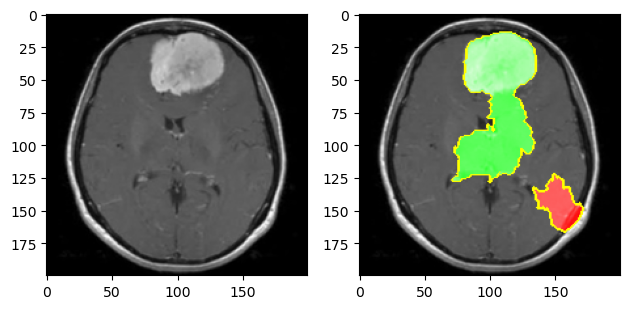

<Figure size 640x480 with 0 Axes>

In [37]:
xAI(cnn_model,"E:/SRM college/SEM-8/brain_tumours/cropped/Testing/meningioma/Te-me_0077.jpg" )
plt.savefig('E:/SRM college/SEM-8/Capstone'+mod+'.png')
plt.savefig('E:/SRM college/SEM-8/Capstone'+mod+'.pdf')